# Lab 9 
Bruce cai

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data,confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from ISLP.models import bs, ns
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator

In this problem, you will use support vector approaches in order to predict whether a given car gets high or low gas mileage based on the Auto data set.


(a)  Create a binary variable that takes on a 1 for cars with gas mileage above the median, and a 0 for cars with gas mileage below the median.

In [16]:
data = load_data("Auto")
mpg01 = []
for i in data["mpg"]:
    if i > np.median(data["mpg"]):
        mpg01.append(1)
    if i < np.median(data["mpg"]):
        mpg01.append(0)

data["mpg01"]=mpg01
print(data.head(5))

                            mpg  cylinders  displacement  horsepower  weight  \
name                                                                           
chevrolet chevelle malibu  18.0          8         307.0         130    3504   
buick skylark 320          15.0          8         350.0         165    3693   
plymouth satellite         18.0          8         318.0         150    3436   
amc rebel sst              16.0          8         304.0         150    3433   
ford torino                17.0          8         302.0         140    3449   

                           acceleration  year  origin  mpg01  
name                                                          
chevrolet chevelle malibu          12.0    70       1      0  
buick skylark 320                  11.5    70       1      0  
plymouth satellite                 11.0    70       1      0  
amc rebel sst                      12.0    70       1      0  
ford torino                        10.5    70       1      0 

(b)  Fit a support vector classifier to the data with various values of C, in order to predict whether a car gets high or low gas mileage. Report the cross-validation errors associated with different values of this parameter. Comment on your results. Note you will need to fit the classifier without the gas mileage variable to produce sensible results.

C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ISLP\svm.py:136: FutureWarning: Series.__getitem__ treating keys a

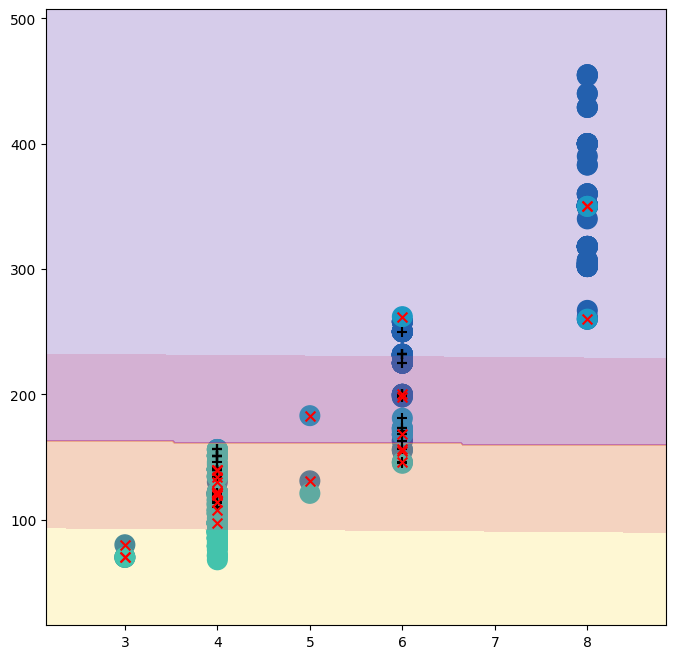

In [17]:
X = data.drop(columns=["mpg01", "mpg"])
y = data["mpg01"]
svm_linear = SVC(C=0.0005, kernel='linear')
svm_linear.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear,
         ax=ax)

In [18]:
C_values = [ 0.0001,0.0005,0.001,0.01,0.1,1, 3,5]
cv_errors = []
for C in C_values:
    svm_model = SVC(C=C, kernel='linear')
    scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
    cv_error = 1 - scores.mean()  # Convert accuracy to error rate
    cv_errors.append(cv_error)
    print(f"C={C}: Cross-Validation Error = {cv_error:.4f}")

C=0.0001: Cross-Validation Error = 0.1022
C=0.0005: Cross-Validation Error = 0.0945
C=0.001: Cross-Validation Error = 0.0971
C=0.01: Cross-Validation Error = 0.1224
C=0.1: Cross-Validation Error = 0.1300
C=1: Cross-Validation Error = 0.1249
C=3: Cross-Validation Error = 0.1249
C=5: Cross-Validation Error = 0.1401


When 𝐶 is extremely low (e.g., 0.0001 or 0.0005), cross-validation errors are actually among the lowest, with the best at 𝐶=0.0005 yielding a cross-validation error of 0.0945.
This suggests that a very flexible margin (with minimal penalty on misclassifications) allows the model to generalize well, likely avoiding overfitting and capturing a simpler, more robust decision boundary.

(c)  Now repeat (b), this time using SVMs with radial and polynomial basis kernels, with different values of gamma and degree and C. Comment on your results.

In [19]:

gamma_values = [0.001, 0.01, 0.1]  

rbf_results = []
for C in C_values:
    for gamma in gamma_values:
        svm_rbf = SVC(C=C, kernel='rbf', gamma=gamma)
        scores = cross_val_score(svm_rbf, X, y, cv=5, scoring='accuracy')
        cv_error = 1 - scores.mean()
        rbf_results.append((C, gamma, cv_error))
        print(f"RBF Kernel - C={C}, gamma={gamma}: CV Error = {cv_error:.4f}")


RBF Kernel - C=0.0001, gamma=0.001: CV Error = 0.3743
RBF Kernel - C=0.0001, gamma=0.01: CV Error = 0.4128
RBF Kernel - C=0.0001, gamma=0.1: CV Error = 0.4564
RBF Kernel - C=0.0005, gamma=0.001: CV Error = 0.3743
RBF Kernel - C=0.0005, gamma=0.01: CV Error = 0.4128
RBF Kernel - C=0.0005, gamma=0.1: CV Error = 0.4564
RBF Kernel - C=0.001, gamma=0.001: CV Error = 0.3743
RBF Kernel - C=0.001, gamma=0.01: CV Error = 0.4128
RBF Kernel - C=0.001, gamma=0.1: CV Error = 0.4564
RBF Kernel - C=0.01, gamma=0.001: CV Error = 0.3743
RBF Kernel - C=0.01, gamma=0.01: CV Error = 0.4128
RBF Kernel - C=0.01, gamma=0.1: CV Error = 0.4564
RBF Kernel - C=0.1, gamma=0.001: CV Error = 0.2807
RBF Kernel - C=0.1, gamma=0.01: CV Error = 0.4128
RBF Kernel - C=0.1, gamma=0.1: CV Error = 0.4564
RBF Kernel - C=1, gamma=0.001: CV Error = 0.0971
RBF Kernel - C=1, gamma=0.01: CV Error = 0.2654
RBF Kernel - C=1, gamma=0.1: CV Error = 0.4642
RBF Kernel - C=3, gamma=0.001: CV Error = 0.1226
RBF Kernel - C=3, gamma=0.01: 

RBF Kernel - C=1, gamma=0.001: CV Error = 0.0971 provide us the possible optimal result with lowest CV error.

C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ISLP\svm.py:136: FutureWarning: Series.__getitem__ treating keys a

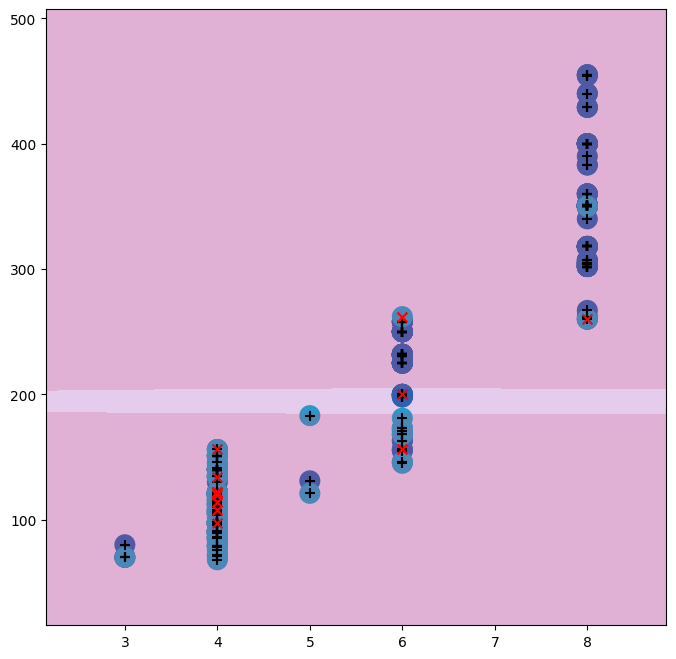

In [20]:
svm_rbf = SVC(C=1, kernel='rbf', gamma=0.001)
svm_rbf.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_rbf,
         ax=ax)

In [21]:
poly_results = []
degree_values = [2, 3, 4,5,6,7,8]
for C in C_values:
    for degree in degree_values:
        svm_poly = SVC(C=C, kernel='poly', degree=degree)
        scores = cross_val_score(svm_poly, X, y, cv=5, scoring='accuracy')
        cv_error = 1 - scores.mean()
        poly_results.append((C, degree, cv_error))
        print(f"Polynomial Kernel - C={C}, degree={degree}: CV Error = {cv_error:.4f}")

Polynomial Kernel - C=0.0001, degree=2: CV Error = 0.4128
Polynomial Kernel - C=0.0001, degree=3: CV Error = 0.4487
Polynomial Kernel - C=0.0001, degree=4: CV Error = 0.4769
Polynomial Kernel - C=0.0001, degree=5: CV Error = 0.4087
Polynomial Kernel - C=0.0001, degree=6: CV Error = 0.3932
Polynomial Kernel - C=0.0001, degree=7: CV Error = 0.3346
Polynomial Kernel - C=0.0001, degree=8: CV Error = 0.3192
Polynomial Kernel - C=0.0005, degree=2: CV Error = 0.4128
Polynomial Kernel - C=0.0005, degree=3: CV Error = 0.4487
Polynomial Kernel - C=0.0005, degree=4: CV Error = 0.3856
Polynomial Kernel - C=0.0005, degree=5: CV Error = 0.3167
Polynomial Kernel - C=0.0005, degree=6: CV Error = 0.2912
Polynomial Kernel - C=0.0005, degree=7: CV Error = 0.2733
Polynomial Kernel - C=0.0005, degree=8: CV Error = 0.2528
Polynomial Kernel - C=0.001, degree=2: CV Error = 0.4128
Polynomial Kernel - C=0.001, degree=3: CV Error = 0.3601
Polynomial Kernel - C=0.001, degree=4: CV Error = 0.3039
Polynomial Kernel

With 𝐶=0.01, the errors decrease substantially, particularly as the polynomial degree increases. For instance, at 𝐶=0.01, the error falls from 0.2043 for degree 2 to 0.1455 for degree 7.

C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ISLP\svm.py:136: FutureWarning: Series.__getitem__ treating keys a

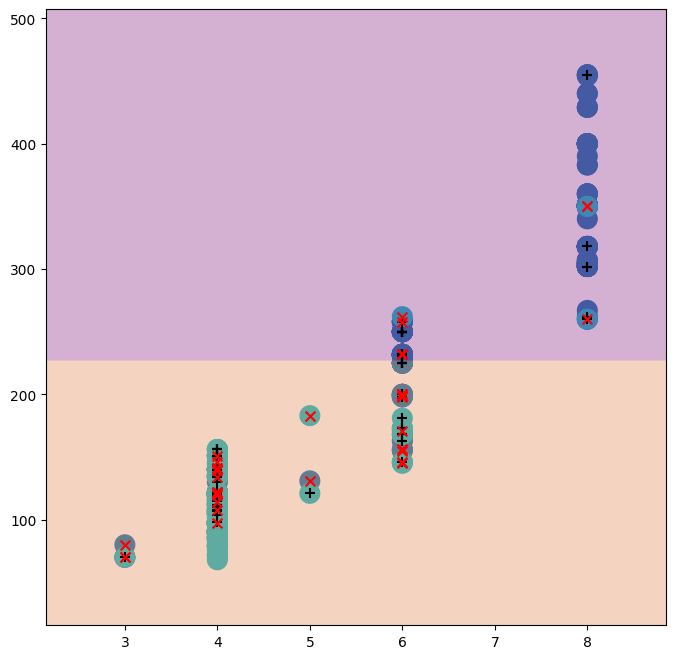

In [23]:
svm_poly = SVC(C=0.1, kernel='poly', degree=3)
svm_poly.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_poly,
         ax=ax)

(d)  Make some plots to back up your assertions in (b) and (c).

The graphs are included in (b) and (c)